In [2]:
print('Meu nome é: Gabriel Moraes Barros ')
print('Meu RA é: 192801')

Meu nome é: Gabriel Moraes Barros 
Meu RA é: 192801


In [3]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import sys
import numpy as np
import numpy.random as nr

import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import (SGD, 
                              RMSprop, 
                              Adam, 
                              Adadelta, 
                              Adagrad)

print('Keras ', keras.__version__)

Using TensorFlow backend.


Keras  2.0.5


In [4]:
import os
os.makedirs('../models', exist_ok=True)
nr.seed(20170603)

In [5]:
!ls ../utils

my_keras_utilities.py  __pycache__


In [6]:
sys.path.append('../utils')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter, train_network)


### Testa se um modulo foi importado

In [7]:
'my_keras_utilities' in sys.modules



True

try:
    train_network(model_week05, model_name, train_generator, validation_generator, **fit_params);
except AttributeError:
      print('nope')

In [8]:
import keras.backend as K
K.set_image_data_format('channels_first')
K.set_floatx('float32')
print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
!nvidia-smib

Backend:        tensorflow
Data format:    channels_first
/bin/sh: 1: nvidia-smib: not found


In [9]:
!ls ../Task\ 5

ls: cannot access '../Task 5': No such file or directory


## Função auxiliar

In [10]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, model_name, train_generator, validation_generator, 
                  train_steps=10, valid_steps=10, opt='rmsprop', nepochs=50, 
                  patience=50, reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = [ModelCheckpoint(model_file, monitor='val_acc', verbose=0, save_best_only=True, mode='auto', period=1),
        MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot), 
        ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=7, verbose=0, mode='auto', epsilon=0.00001, cooldown=0, min_lr=0)
     ]
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb[1].get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs ...".format(tr_epochs))
    try:
        model.fit_generator(train_generator, steps_per_epoch=train_steps,
                            validation_data=validation_generator, validation_steps=valid_steps,
                            epochs=nepochs, verbose=vv, callbacks=[cb[1]])
    except KeyboardInterrupt:
        pass

    model, histo = load_model_and_history(model_name)
    return model, cb


def test_network(model_name, validation_generator, nb_validation_samples):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate_generator(validation_generator, nb_validation_samples)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


## Subindo o dataset

In [11]:
#auternar o comentário, se estiver no client ou no remote
data = np.load('/etc/jupyterhub/ia368z_2s2017/datasets/cifar10-redux.npz')
#data = np.load('../Task 5/cifar10-redux.npz')

In [12]:
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

In [13]:
X_train.dtype, y_train.dtype, X_test.dtype, y_test.dtype

(dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('int64'))

### Separando o conjunto de treinamento em validação e treinamento, numa proporção 80/20 %


In [14]:
p=np.random.permutation(len(X_train))
percent_factor=0.85
new_train_x = X_train[p]
new_train_y = y_train[p]


new_X_train = new_train_x[0:(np.floor(len(new_train_x)*percent_factor))]
new_y_train = new_train_y[0:(np.floor(len(new_train_y)*percent_factor))]
new_X_val = new_train_x[(np.ceil(len(new_train_x)*percent_factor)):]
new_y_val = new_train_y[(np.ceil(len(new_train_y)*percent_factor)):]


/home/adessowiki/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/adessowiki/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/adessowiki/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/adessowiki/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [15]:
print('X_train.shape',new_X_train.shape)
print('y_train.shape',new_y_train.shape)
print('X_val.shape',new_X_val.shape)
print('y_val.shape',new_y_val.shape)
print('y_test shape ',y_test.shape)
print('X_test.shape:',X_test.shape)


X_train.shape (1700, 3, 32, 32)
y_train.shape (1700,)
X_val.shape (300, 3, 32, 32)
y_val.shape (300,)
y_test shape  (500,)
X_test.shape: (500, 3, 32, 32)


In [16]:
print('Número de diferentes classes',len(np.unique(y_test)))


Número de diferentes classes 3


Normalizando os dados

In [17]:
a=0
print(np.mean(X_train))

113.781868652


#Guaranteeing that it only runs once
if (a==0):
    X_test = X_test.astype('float32')
    new_X_train = new_X_train.astype('float32')
    new_X_val = new_X_val.astype('float32')
    
    new_X_val /= 255.
    new_X_train /= 255.
    X_test /= 255.
    
    a=1
print(np.mean(new_X_train))
print(np.mean(new_X_val))
print(np.mean(X_test))

In [18]:
from keras.utils import np_utils

## Transforma o vetor de labels para o formato de one-hot encoding.
n_classes = 3
y_train_oh = np_utils.to_categorical(new_y_train-3, n_classes)
y_val_oh = np_utils.to_categorical(new_y_val-3, n_classes)
y_test_oh = np_utils.to_categorical(y_test-3, n_classes)

In [19]:
print(y_train_oh.shape)
print(y_val_oh.shape)
print(y_test_oh.shape)


(1700, 3)
(300, 3)
(500, 3)


## Fazendo o data augmentation

In [20]:
print(X_train.shape)
print(X_test.shape)

(2000, 3, 32, 32)
(500, 3, 32, 32)


In [21]:
print('new x train shape', new_X_train.shape)
print('y train oh shape', y_train_oh.shape)

print('new x val shape', new_X_val.shape)
print('y val oh shape', y_val_oh.shape)



new x train shape (1700, 3, 32, 32)
y train oh shape (1700, 3)
new x val shape (300, 3, 32, 32)
y val oh shape (300, 3)


In [22]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
nb_train_samples = new_train_x.shape[0]
nb_val_samples = new_X_val.shape[0]
print('nb val samples',nb_val_samples)
nb_test_samples = X_test.shape[0]

# dimensions of our images.
img_width, img_height = 32, 32
batch_size=100

nb val samples 300


In [23]:
# this is the augmentation configuration we will use for training
aug_datagen = ImageDataGenerator(
       rescale=1./255,         # sempre faz o rescale
       shear_range=0.2,        # sorteio entre 0 e 0.2 distribuição uniforme
       zoom_range=0.2,         # sorteio entre 0 e 0.2
       horizontal_flip=True)   # sorteio 50%

non_aug_datagen = ImageDataGenerator( rescale=1./255)

In [24]:
train_generator = aug_datagen.flow(
        x = new_X_train, y = y_train_oh,                       # as amostras de treinamento
        batch_size=batch_size,shuffle=False                # batch size do SGD
        )

validation_generator = non_aug_datagen.flow(
        x = new_X_val, y = y_val_oh,                  # as amostras de validação
        batch_size=batch_size, shuffle = False)

In [25]:
test_generator = non_aug_datagen.flow(
        x = X_test, y = y_test_oh,                  # as amostras de validação
        batch_size=batch_size, shuffle = False)

#Conjunto de treinaemnto
samples_train = train_datagen.flow(new_X_train)
n_samples_train = nb_train_samples/batch_size

#Conjunto de teste
samples_test = train_datagen.flow(X_test)
n_samples_test = nb_test_samples/batch_size
#Conjunto de validacao

samples_val = train_datagen.flow(new_X_val)
n_samples_val = nb_val_samples/batch_size

In [27]:
n_classes = len(np.unique(y_test))
print(n_classes)

3


## Treinamento

# Transfer_Learning


## Subindo a VGG-16

In [28]:
print(y_train_oh.shape)

(1700, 3)


In [29]:
from keras.applications.vgg16 import VGG16
modelvgg = VGG16(include_top=False, weights='imagenet',classes=y_train_oh.shape[1])


/home/adessowiki/anaconda3/lib/python3.6/site-packages/keras/applications/vgg16.py:181: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


In [30]:
train_feature = modelvgg.predict_generator(generator=train_generator, steps=int(np.round(train_generator.n / batch_size)))
print(train_feature.shape, train_feature.dtype)
validation_features = modelvgg.predict_generator(generator = validation_generator, steps=int(np.round(validation_generator.n / batch_size)))
print(validation_features.shape, validation_features.dtype)

(1700, 512, 1, 1) float32
(300, 512, 1, 1) float32


In [ ]:
train_feature.shape

topmodel.summary()

modelvgg.summary()

In [34]:
train_feature.shape[1:]
train_feat = train_feature.reshape(1700,512)
print(train_feat.shape)

(1700, 512)


In [ ]:
modelvgg.output

In [32]:
def model_build():
    img_rows, img_cols = 32, 32 # Dimensões das imagens
    #imagens com 3 canais e 32x32
    input_shape = (3, img_rows, img_cols)

    # Definindo a rede
    model = Sequential()
    #primeira conv
    model.add(Conv2D(32, (3, 3),
                     input_shape=input_shape))
    model.add(Activation('relu'))
    
    #segunda conv
    model.add(Conv2D(32,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    # Aqui os features deixam de ser imagens
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes))
    model.add(Activation('softmax'))
    return model
model_week05 = model_build()

In [33]:
model_week05.load_weights('../my_cifar_dataplus_model_weights.h5')
print("done")

done


In [36]:
model_week05.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 30, 30)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 30, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 28, 28)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 28, 28)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 14, 14)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 14, 14)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
__________

In [43]:
print(model_week05.layers)
print(len(model_week05.layers))
weights10 = model_week05.layers[10].get_weights()
print(weights10[0].shape,weights10[1].shape)
weights7 = model_week05.layers[7].get_weights()
print(weights7[0].shape,weights7[1].shape)


[<keras.layers.convolutional.Conv2D object at 0x7f2475f62048>, <keras.layers.core.Activation object at 0x7f246f82e390>, <keras.layers.convolutional.Conv2D object at 0x7f246f82e7f0>, <keras.layers.core.Activation object at 0x7f246c636fd0>, <keras.layers.pooling.MaxPooling2D object at 0x7f2475f61fd0>, <keras.layers.core.Dropout object at 0x7f246c5f5e80>, <keras.layers.core.Flatten object at 0x7f2475f62b70>, <keras.layers.core.Dense object at 0x7f24b0f24a20>, <keras.layers.core.Activation object at 0x7f246c696630>, <keras.layers.core.Dropout object at 0x7f246c696cc0>, <keras.layers.core.Dense object at 0x7f246c696b00>, <keras.layers.core.Activation object at 0x7f24702d7cc0>]
12
(128, 3) (3,)
(6272, 128) (128,)


In [50]:
w2, b2 = weights10
w1, b1 = weights7


In [44]:
topmodel = Sequential()
topmodel.add(layer=keras.layers.Flatten(input_shape=(1,1,512)))
# topmodel.add(layer=keras.layers.Dense(units=256, activation='relu', name='d256'))

topmodel.add(layer=keras.layers.Dense(units=128, name='d256',))
topmodel.add(Activation('relu'))
topmodel.add(layer=keras.layers.Dropout(rate=.5))
topmodel.add(layer=keras.layers.Dense(units=3, name='d3'))
topmodel.add(Activation('softmax'))
# topmodel.compile(optimizer=keras.optimizers.SGD(lr=.05, momentum=.9, nesterov=True),
topmodel.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [45]:
topmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
d256 (Dense)                 (None, 128)               65664     
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
d3 (Dense)                   (None, 3)                 387       
_________________________________________________________________
activation_6 (Activation)    (None, 3)                 0         
Total params: 66,051
Trainable params: 66,051
Non-trainable params: 0
_________________________________________________________________


In [47]:
print(topmodel.layers)
print(len(topmodel.layers))

[<keras.layers.core.Flatten object at 0x7f2470139198>, <keras.layers.core.Dense object at 0x7f2470139208>, <keras.layers.core.Activation object at 0x7f247021f828>, <keras.layers.core.Dropout object at 0x7f2470139ba8>, <keras.layers.core.Dense object at 0x7f24701392e8>, <keras.layers.core.Activation object at 0x7f24701396a0>]
6


In [49]:
topmodel.layers[20].set_weights([w1, b1])
topmodel.layers[5].set_weights([wei])

ValueError: You called `set_weights(weights)` on layer "activation_5" with a  weight list of length 2, but the layer was expecting 0 weights. Provided weights: [array([[ 0.02028346,  0.01141502, -0.00417125, .....

In [108]:
!ls ../

cifar_redux_augmented_vgg.history   utils   week05
cifar_redux_augmented_vgg.model     week02  week06
models				    week03
my_cifar_dataplus_model_weights.h5  week04


w1, b1, w2, b2 = load_model('../my_cifar_dataplus_model_weights.h5').get_weights()   

w1, b1, w2, b2 = load_model('../my_cifar_dataplus_model_weights').get_weights()m m  mmm

In [103]:
model2.load_weights('../my_cifar_dataplus_model_weights.h5')


ValueError: You are trying to load a weight file containing 4 layers into a model with 2 layers.


    # Aqui os features deixam de ser imagens
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes))
    model.add(Activation('softmax'))

topmodel = Sequential()
# topmodel.add(layer=keras.layers.Flatten(input_shape=feat_train.shape[1:]))
# topmodel.add(layer=keras.layers.Dense(units=256, activation='relu', name='d256'))
topmodel.add(layer=keras.layers.Dense(units=256, activation='relu', name='d256', input_shape=(1,1,512)))
topmodel.add(layer=keras.layers.Dropout(rate=.5))
topmodel.add(layer=keras.layers.Dense(units=3, activation='softmax', name='d3'))

# topmodel.compile(optimizer=keras.optimizers.SGD(lr=.05, momentum=.9, nesterov=True),
topmodel.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

#train_features = modelvgg.predict(new_X_train)
train_features = modelvgg.predict(new_X_train)

print('train_features shape and type',train_features.shape,train_features.dtype)
validation_features = modelvgg.predict(new_X_val)
print('validation_features shape and type',validation_features.shape,train_features.dtype)
test_features = modelvgg.predict(X_test)
print('test_features shape and type',test_features.shape,train_features.dtype)

In [ ]:
modelvgg.layers.pop(18)
modelvgg.layers.pop(17)
modelvgg.layers.pop(16)
modelvgg.layers.pop(15)

In [ ]:
#modelvgg.summary()

In [ ]:
train_features = modelvgg.predict(new_X_train)
print('train_features shape and type',train_features.shape,train_features.dtype)
validation_features = modelvgg.predict(new_X_val)
print('validation_features shape and type',validation_features.shape,train_features.dtype)
test_features = modelvgg.predict(X_test)
print('test_features shape and type',test_features.shape,train_features.dtype)

In [ ]:
train_features.shape[1:]

In [ ]:
model_name = '../cifar_redux_augmented_vgg'

modelVGG = Sequential()
modelVGG.add(Flatten(input_shape= train_features.shape[1:]))    
modelVGG.add(Dense(120))
modelVGG.add(Activation('relu'))
modelVGG.add(Dropout(0.5))
modelVGG.add(Dense(3))
modelVGG.add(Activation('softmax'))

In [ ]:
modelVGG.summary()

## Treinando class MyCb(TrainingPlotter):
    

In [ ]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, model_name, Xtra, ytra, Xval, yval, 
                  opt='rmsprop', batch_size=100, nepochs=50, patience=50, reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs ...".format(tr_epochs))
    try:
         model.fit(Xtra, ytra, batch_size=batch_size, epochs=tr_epochs, verbose=vv, 
                      validation_data=(Xval,yval), callbacks=[cb])
    except KeyboardInterrupt:
        pass

    model, histo = load_model_and_history(model_name)
    return model, cb


def test_network(model_name, Xtest, ytest, batch_size=40):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate(Xtest, ytest, batch_size=batch_size, verbose=1)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))

In [ ]:
print('train_features.shape',train_features.shape)
print('validation_features.shape',validation_features.shape)
print('test_features.shape',test_features.shape)



In [ ]:
fit_params = {
    'opt':         'adam',           # SGD(lr=0.01, momentum=0.9, nesterov=True), 
    'nepochs':         100, 
    'patience':        30,
    'ploss':           1.5,
    'reset':           True,
}

train_network(modelVGG, model_name, train_features, y_train_oh, validation_features, y_val_oh,  **fit_params);

In [ ]:
test_network(model_name, test_features,y_test_oh,X_test.shape[0])

In [ ]:
from keras.applications.vgg16 import VGG16

print("[INFO] creating model...")
#vgg = VGG16(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
vgg = VGG16(include_top=False, weights='imagenet')
vgg.summary()

## Construção da rede neural

In [ ]:
print(train_features.shape)
print(new_X_train.shape)

In [45]:
img_height, img_width = new_X_train.shape[2],new_X_train.shape[3]
print(img_height,img_width)

32 32


In [52]:
!ls ..

cifar_redux_augmented_vgg.history  models  week02  week04  week06
cifar_redux_augmented_vgg.model    utils   week03  week05


In [ ]:
from keras.models import Model
from keras.models import load_model

model_name = '../cifar10_vgg_finetune'   # modelo da rede atual
top_model_name = '../cifar_redux_augmented_vgg'
nb_classes=3

In [70]:
def build_net(top_model_name):
    from keras.applications.vgg16 import VGG16
    
    print("[INFO] creating model...")
    #vgg = VGG16(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
    #vgg = VGG16(include_top=False, weights='imagenet', input_shape=(3,img_height, img_width))
    vgg = VGG16(include_top=False, weights='imagenet', classes=nb_classes, pooling='max')
    
    print(vgg.output)
    # build a classifier model and put on top of the convolutional model
    #x = Flatten()(vgg.output)
    x = Dense(120, activation='relu', name='dense1')(vgg.output)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='relu', name='d1')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid', name='d2')(x)
    
    #x = Dense(40, activation='relu', name='dense1')(vgg.output)
   # x = Dropout(0.5)(x)
    #x = Dense(120, activation='relu', name='dense2')(x)
    #x = Dropout(0.2)(x)
    #x = Dense(nb_classes, activation='softmax', name='dense3')(x)

    #model = Model(inputs=vgg.input, outputs=x
    
    
    model = Model(inputs=vgg.input, outputs=x)
    print(model.layers)
    print(len(model.layers))    #     print('Model layers:')
    #     for i, layer in enumerate(model.layers):
    #         print('    {:2d} {:15s} {}'.format(i, layer.name, layer))
    
    # modelo da rede densa treinada no notebook anterior
    top_model_name = top_model_name
    # Carrego os pesos treinados anteriormente
    #w1, b1, w2, b2 = load_model(top_model_name).get_weights()    
    w1, b1, w2, b2 = modelVGG.get_weights()    
    print(w1.shape,b1.shape,w2.shape,b2.shape)
    # Coloco nas camadas densas finais da rede
    model.layers[20].set_weights([w1, b1])
    model.layers[22].set_weights([w2, b2])
    
    # Torno não-treináveis as primeiras 15 camadas
    # da rede (os pesos não serão alterados)
    for layer in model.layers[:15]:
        layer.trainable = False
        
    return model

model = build_net(top_model_name)

[INFO] creating model...


/home/adessowiki/anaconda3/lib/python3.6/site-packages/keras/applications/vgg16.py:181: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


Tensor("global_max_pooling2d_20/Max:0", shape=(?, 512), dtype=float32)
[<keras.engine.topology.InputLayer object at 0x7f1ee4f962e8>, <keras.layers.convolutional.Conv2D object at 0x7f1ee4f965f8>, <keras.layers.convolutional.Conv2D object at 0x7f1ee502db38>, <keras.layers.pooling.MaxPooling2D object at 0x7f1ee4f964a8>, <keras.layers.convolutional.Conv2D object at 0x7f1ee4fe2588>, <keras.layers.convolutional.Conv2D object at 0x7f1ee4fe24a8>, <keras.layers.pooling.MaxPooling2D object at 0x7f1ee4ff1d30>, <keras.layers.convolutional.Conv2D object at 0x7f1ee4e6aef0>, <keras.layers.convolutional.Conv2D object at 0x7f1ee4efb9e8>, <keras.layers.convolutional.Conv2D object at 0x7f1ee4e78c18>, <keras.layers.pooling.MaxPooling2D object at 0x7f1ee4e037b8>, <keras.layers.convolutional.Conv2D object at 0x7f1ee4dadc50>, <keras.layers.convolutional.Conv2D object at 0x7f1ee4dbd7f0>, <keras.layers.convolutional.Conv2D object at 0x7f1ee4d65ba8>, <keras.layers.pooling.MaxPooling2D object at 0x7f1ee4d735c0>,

In [72]:
#model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
batch_size = 40

In [79]:
print(new_X_train.shape, y_train_oh.shape,new_X_val.shape, y_val_oh.shape)

(1700, 3, 32, 32) (1700, 3) (300, 3, 32, 32) (300, 3)


(1600, 32, 32, 3) (1600, 3) (400, 32, 32, 3) (400, 3)


In [81]:
h = model.fit(new_X_train.reshape(1700,3,32,32), y_train_oh,
              validation_data=(new_X_val.reshape(300,3,32,32), y_val_oh),
              batch_size=batch_size,
              epochs=100,
              )

ValueError: Error when checking target: expected d2 to have shape (None, 1) but got array with shape (1700, 3)

In [ ]:
h = model.fit(X_train[train_i], y_train_oh[train_i],
              validation_data=(X_train[val_i], y_train_oh[val_i]),
              batch_size=batch_size,
              epochs=400,
              callbacks=[early_stopping, checkpointer, reduce_lr], verbose=1)

[INFO] compiling model...
[INFO] training for 100 epochs ...


ValueError: Error when checking input: expected input_25 to have shape (None, 3, None, None) but got array with shape (1700, 512, 1, 1)

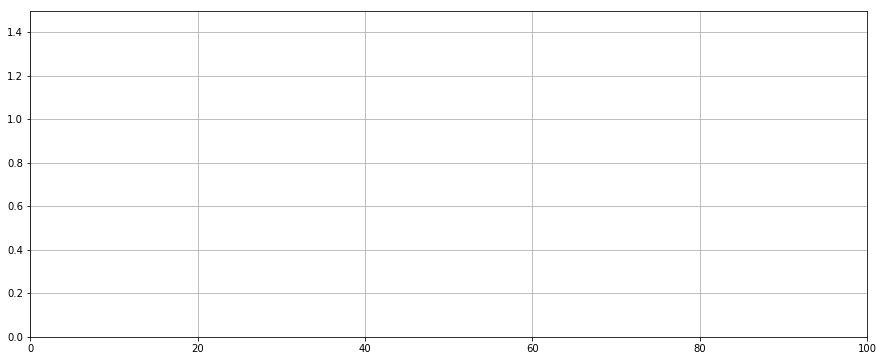

In [73]:

model_name = '../cifar10_vgg_finetune'
fit_params = {
    'opt':         'adam',           # SGD(lr=0.01, momentum=0.9, nesterov=True), 
    'nepochs':         100, 
    'patience':        30,
    'ploss':           1.5,
    'reset':           True,
}

train_network(model, model_name, train_features, y_train_oh, validation_features, y_val_oh,  **fit_params);